# Mercari Data Capstone Project - Exploratory Data Analysis

After we've finished the data wrangling portion of the project where we investigated each column separately, it is now time to start investigating relationships and correlations between each of our columns. Our target here is 'Price', so we'll be exploring how every other column and combination of other columns may affect the Price.

To start off, we'll quickly import packages and our dataset, and then check to see if it was imported correctly.

In [1]:
#imports

import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from scipy.stats import chi2_contingency

In [2]:
path = "/Users/jasonzhou/Documents/GuidedCapstone2"
os.chdir(path)

mercari_data = pd.read_csv("MercariDataCleaned.csv")
mercari_data = mercari_data.drop(columns=['Unnamed: 0'])

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# Check to see if data was imported correctly
mercari_data.head()

,Condition,Category,Brand,Price,Shipping
0,5,Beauty/Makeup/Lips,Sephora,3.80735,1
1,5,Beauty/Makeup/Lips,Sephora,3.80735,0
2,3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,6.30378,0
3,5,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,5.39232,1
4,3,Women/Dresses/Knee-Length,Customized & Personalized,4.80735,0


In [4]:
mercari_data.shape

(567252, 5)

In [5]:
# Checking for missing values
missing = pd.concat([mercari_data.isnull().sum(), 100 * mercari_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Condition,0,0.00000
Category,0,0.00000
Brand,0,0.00000
Price,0,0.00000
Shipping,0,0.00000


# Individual Columns vs. Price

Lets start with the noncategorical features of the data, which would only be Condition. 

The intuitive prediction is that the better condition an item is in, the higher the price you can charge for it. Therefore we are expecting to see any kind of positive correlation.

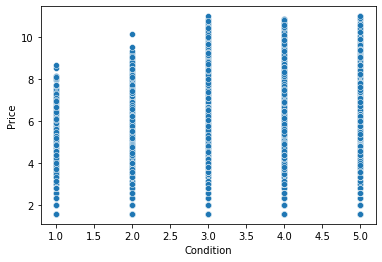

In [6]:
# Lets try to investigate and look for any correlations
_ = sns.scatterplot(data=mercari_data, x='Condition', y='Price')

It's difficult to visualize the correlation here. As we learned from our data wrangling, the mass majority of data points have a price value of about 130 or less. 130 is miniscule compared to the overall height of the graph, and therefore the majority of data points are hidden due to overlap near the bottom. We will just have to find out the correlation coefficient directly numerically:

In [7]:
mercari_data[['Price', 'Condition']].corr()

,Price,Condition
Price,1.00000,0.07189
Condition,0.07189,1.00000


So while it does appear that Price does technically correlate positively with Condition, the magnitude of it is extremely low. It is low enough that the takeaway here should be to assume that Condition alone has no particular effect on Price. 

Upon further thinking this does seem to make sense. An item's condition should theoretically affect the pricing of it to some degree, but this effect will be tiny compared to what the item itself is. No matter what condition an item is in, there is still a bare minimum you can charge for it even if it is in the poorest condition. For example, a pair of worn down limited edition Jordans would still sell for far more than a brand new pair of generic socks.

The conclusion to be had here is that Condition by itself is not much of a predictor of Price.

Let us now move on to Brand.

Brand should absolutely have an effect on the price of an item. Nike products for example should sell for higher prices than cheaper shoe or clothing brands. Even when comparing items of different categories, you would expect an electronics brand to sell their items for higher prices than for a clothing brand.

Brand is a non-numeric and categorical column, so we can't determine correlation with Price like we did with Condition. We will instead use one way ANOVA testing with the following hypothesis testing:

h0: Brand has no significant effect on Price

h1: Brand does have a significant effect on Price

In [8]:
# Get number of unique values of 'Brand'

print(mercari_data['Brand'].nunique())

# Lets then identify the Brands that are most present in the data

print(mercari_data['Brand'].value_counts())

675
PINK                 37952
Nike                 37933
Victoria's Secret    34018
LuLaRoe              21761
Apple                12145
                     ...  
Aveeno                  45
Everlast                42
Spyder                  40
Babies R Us             38
Safety st               15
Name: Brand, Length: 675, dtype: int64


In [9]:
# One way Anova on 'Brand'
from scipy.stats import f_oneway

brandPriceDict = {}

for brand in mercari_data['Brand'].unique().tolist():
    pricesList = []
    for price in mercari_data['Price'][mercari_data['Brand'] == brand]:
        pricesList.append(price)
    brandPriceDict[brand] = np.array(pricesList)

In [10]:
f_oneway(*brandPriceDict.values())

F_onewayResult(statistic=406.64640611634087, pvalue=0.0)

Because our pvalue was less than 0.05, we can conclude that Brand does in fact have an effect on the price of a listing. We would be shocked if this wasn't the case, as common sense tells us that branding makes a big difference on how much the same kind of product can cost. Let's get a better visual idea on how Brand affects Price:

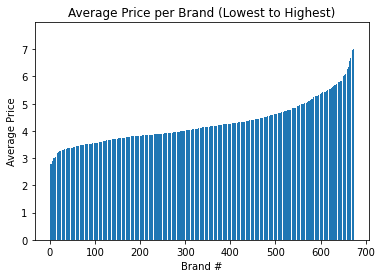

In [12]:
meanPricePerBrand = mercari_data.groupby('Brand').mean()['Price'].sort_values()

_ = plt.bar(range(675), list(meanPricePerBrand))
_ = plt.xlabel('Brand #')
_ = plt.ylabel('Average Price')
_ = plt.title('Average Price per Brand (Lowest to Highest)')

The distributions of mean price per brand is fairly uniform, with the vast majority of mean prices being below 100.

Now let's do the same for Category.

Category should certainly have an effect of the price of a listing. For example, an item under the category of computer should sell for far than an item in the socks category.

h0: Category has no significant effect on Price

h1: Category does have a significant effect on Price

In [13]:
# Get number of unique values of 'Category'

print(mercari_data['Category'].nunique())

print(mercari_data['Category'].value_counts())

416
Women/Athletic Apparel/Pants, Tights, Leggings    25277
Women/Tops & Blouses/T-Shirts                     22467
Beauty/Makeup/Face                                17289
Electronics/Video Games & Consoles/Games          13998
Beauty/Makeup/Lips                                13329
                                                  ...  
Kids/Safety/Monitors                                 55
Beauty/Other/Other                                   52
Other/Daily & Travel items/Household Supplies        52
Sports & Outdoors/Fan Shop/MLB                       52
Other/Automotive/Tools & Equipment                   51
Name: Category, Length: 416, dtype: int64


In [14]:
# One way Anova on 'Category'
categoryPriceDict = {}

for category in mercari_data['Category'].unique().tolist():
    pricesList = []
    for price in mercari_data['Price'][mercari_data['Category'] == category]:
        pricesList.append(price)
    categoryPriceDict[category] = np.array(pricesList)

In [15]:
f_oneway(*categoryPriceDict.values())

F_onewayResult(statistic=541.4978314714351, pvalue=0.0)

Again we've ended up with a p-value of less than 0.05 so we can reject the null hypothesis and can conclude that category does have an effect on Price. This matches our intuition because for example, anything under the computer category is going to sell for way more than say a pair of socks. Again, let's look at a distribution of mean prices per category:

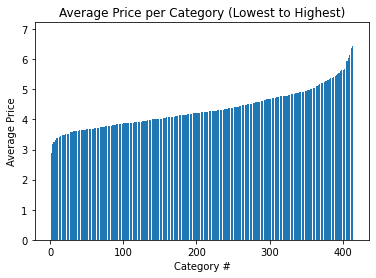

In [16]:
meanPricePerCategory = mercari_data.groupby('Category').mean()['Price'].sort_values()

_ = plt.bar(range(416), list(meanPricePerCategory))
_ = plt.xlabel('Category #')
_ = plt.ylabel('Average Price')
_ = plt.title('Average Price per Category (Lowest to Highest)')

This graph is less polarized than that of Brands, most likely because there are less categories and therefore the individual group data sets have somewhat less variance. Compared to mean price per brand, the increase is more gradual.

Now let's look at Shipping.

This one isn't so intuitive. I'm unsure of whether or not Shipping should even have an effect on Price. But if it does, then my initial guess would be that listings where the seller doesn't pay for shipping should be on average cheaper. My reasoning for this is that sellers wouldn't want to scare off buyers from paying a regular price and then with shipping costs on top of that.

Because there are only two groups in Shipping, we can just do a simple t test.

h0: Shipping has no significant effect on Price

h1: Shipping does have a significant effect on Price

In [17]:
from scipy import stats
import statistics

ship0 = mercari_data['Price'][mercari_data['Shipping'] == 0]
ship1 = mercari_data['Price'][mercari_data['Shipping'] == 1]

var0 = statistics.variance(ship0)
var1 = statistics.variance(ship1)

print(var0)
print(var1)

1.1312163977475287
1.4343694970102776


In [18]:
# Because the variances of the two sets of data aren't quite the same, we specify that in our test
stats.ttest_ind(ship0, ship1, equal_var=False)

Ttest_indResult(statistic=136.12715702610217, pvalue=0.0)

Because the p-value is less than 0.05, we must reject the null hypothesis and conclude that the status of Shipping does in fact have an effect on the Price of the listing. An explanation for this is not so straightforward. Lets first get a visual representation of the mean price per shipping:

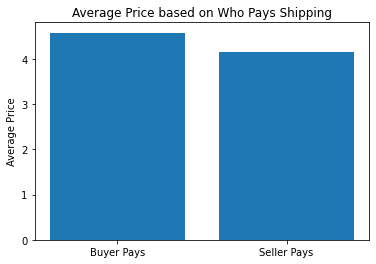

In [19]:
_ = plt.bar(['Buyer Pays', 'Seller Pays'], [ship0.mean(), ship1.mean()])
_ = plt.ylabel('Average Price')
_ = plt.title('Average Price based on Who Pays Shipping')

This goes against my initial prediction that listings where the seller doesn't pay for shipping will be cheaper on average. Upon seeing that it's actually the opposite that's true, I have a possible explanation. Listings that are higher in demand can be charged more for AND sellers have the luxury of having buyers pay for shipping too. 

# Combination of Columns vs. Price

During our investigation of individual columns, we discovered that Condition on its own has no effect on the outcome of Price. However, I am still not convinced that it is an irrelevant column of information. Everything else equal, a listing with a condition value of 5 should be able to sell for more than if it had a condition value of 1. I specifically want to test the effects of Condition + Brand, and Condition + Category on the price. Let's begin with the former.

To see if Condition is relevant here, we will use the Pearson Chi Square Test. To set up the contigency table, we can only have a single value for every Brand - Condition pair. To deal with this, we will simply take averages. For missing Brand - Condition pairs, we will just fill in the overall mean of the price column. Our hypothesis is the following:

h0: There is no relation between the variables of Category and Brand

h1: There is significant relation between the variables of Category and Brand

In [20]:
from scipy.stats import chi2_contingency

# Lets take get 5 rows of average price per brand, 1 for each Condition value

conditions = [1, 2, 3, 4, 5]
conttable = []

# For the brands that don't have a listing with a certain condition, we just fill in the first value. We'll account
# for this in the analysis later

# In case of nan, just fill in the total average price of the dataset
totalmean = mercari_data['Price'].mean()

for condition in conditions:
    brandlist = []
    for brand in list(mercari_data['Brand'].unique()):
        if mercari_data['Price'][(mercari_data['Condition']==1) & (mercari_data['Brand']==brand)].any():
            brandlist.append(mercari_data['Price'][(mercari_data['Condition']==condition) & (mercari_data['Brand']==brand)].mean())
        else:
            value = float(mercari_data['Price'][mercari_data['Brand']==brand].head(1))
            brandlist.append(totalmean if np.isnan(value) else value)
    conttable.append(brandlist)
        
        

In [21]:
# create a cleaned version of conttable without nan values
cleanedconttable = []

for row in conttable:
    temp = []
    for item in row:
        if (np.isnan(item)) or (item == 0.0):
            temp.append(totalmean)
        else:
            temp.append(item)
    cleanedconttable.append(temp)

In [22]:
# Called built-in chi2 test and find p value
stat, p, dof, expected = chi2_contingency(cleanedconttable)

alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')

p value is 1.0
Independent (H0 holds true)


So while there are circumstances about our data that made this chi-squared less than ideal, it is still surprising to see the p-value be so high. Perhaps we need to consider that Condition is truly not as relevant as we'd thought it'd be.

Let's carry on the same procedure but for Category.

h0: There is no relation between the variables of Condition and Category

h1: There is significant relation between the variables of Condition and Category

In [23]:
# Lets take get 5 rows of average price per brand, 1 for each Condition value

conttable1 = []

for condition in conditions:
    categorylist = []
    for category in list(mercari_data['Category'].unique()):
        if mercari_data['Price'][(mercari_data['Condition']==1) & (mercari_data['Category']==category)].any():
            categorylist.append(mercari_data['Price'][(mercari_data['Condition']==condition) & (mercari_data['Category']==category)].mean())
        else:
            value = float(mercari_data['Price'][(mercari_data['Category']==category)].head(1))
            categorylist.append(totalmean if np.isnan(value) else value)
    conttable1.append(categorylist)
    
    
    

In [24]:
# create a cleaned version of conttable without nan values
cleanedconttable1 = []

for row in conttable1:
    temp = []
    for item in row:
        if (np.isnan(item)) or (item == 0.0):
            temp.append(totalmean)
        else:
            temp.append(item)
    cleanedconttable1.append(temp)

In [25]:
stat, p, dof, expected = chi2_contingency(cleanedconttable1)

alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')

p value is 1.0
Independent (H0 holds true)


While the p-value this time is much lower this time, it's still far from being less than 0.05. Based on both of these chi-squared tests, we really do have to consider that the Condition column is not much of a predictor when it comes to Price. 

# Summary and Conclusion

We've concluded that the columns of Brand, Category, and Shipping are reasonable predictors of price. Condition, neither by itself or paired with other columns have much of an effect on Price. 

Brand and Category make sense. Some brands are more luxurious than others, and of course the category of the item itself is going to greatly determine what its monetary value is. 

Shipping is still somewhat of a headscratcher. Most likely, the shipping status itself doesn't influence the price of a listing. As we theorized earlier, different listings vary in demand, and listings in higher demand would be able to defer shipping fees to the buyer since they will be willing to pay it anyways.